In [401]:
# Importing the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [289]:
# Reading the data
concrete_df = pd.read_csv("concrete.csv")
concrete_df.head(10)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
5,255.0,0.0,0.0,192.0,0.0,889.8,945.0,90,21.86
6,166.8,250.2,0.0,203.5,0.0,975.6,692.6,7,15.75
7,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,56,36.64
8,296.0,0.0,0.0,192.0,0.0,1085.0,765.0,28,21.65
9,155.0,184.0,143.0,194.0,9.0,880.0,699.0,28,28.99


## Deliverable 1 - EDA 

In [269]:
# Shape of data - 1030 rows and 9 columns
concrete_df.shape

(1030, 9)

In [270]:
# Dataset information
concrete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [457]:
# Statistical summary of the dataset
concrete_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.90000,350.000,540.0
slag,1030.0,73.240680,85.384419,0.00,0.000,22.00000,142.725,342.1
ash,1030.0,54.188350,63.997004,0.00,0.000,0.00000,118.300,200.1
water,1030.0,181.653107,20.603205,126.60,164.900,185.00000,192.000,228.0
superplastic,1030.0,5.973592,5.477165,0.00,0.000,6.40000,10.075,23.4
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.00000,1029.400,1145.0
fineagg,1030.0,777.946019,72.366929,605.00,745.000,779.45000,822.200,945.0
age,1030.0,23.757282,14.139707,1.00,7.000,28.00000,28.000,56.0
strength,1030.0,35.418692,16.178874,2.33,23.710,34.41125,45.300,78.8


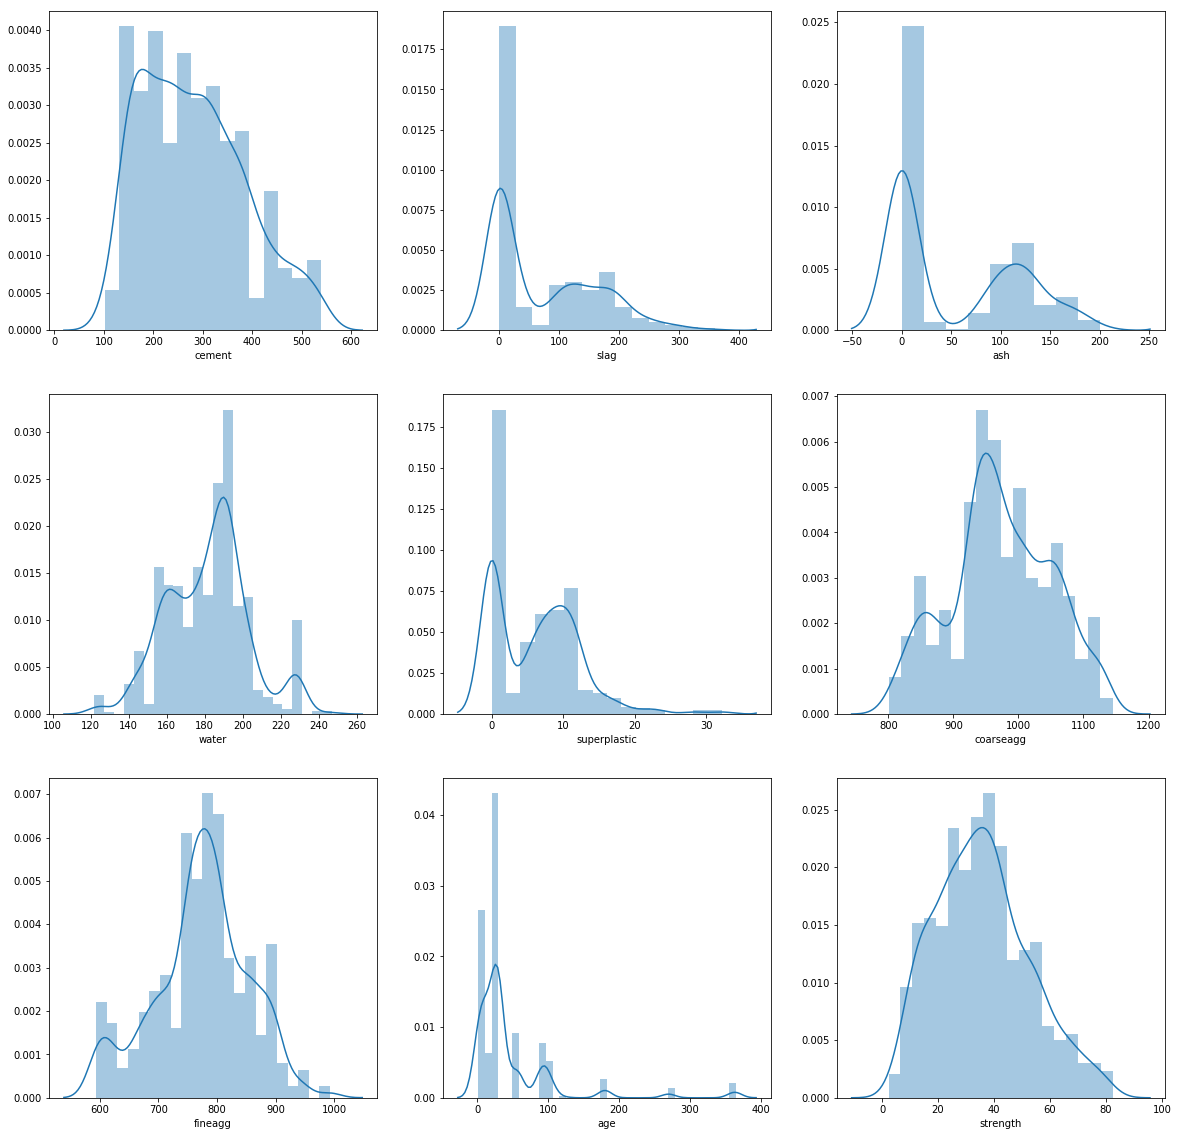

In [149]:
# Distribution plot for all attributes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
for i, column in enumerate(concrete_df.columns):
    sns.distplot(concrete_df[column],ax=axes[i//3,i%3])

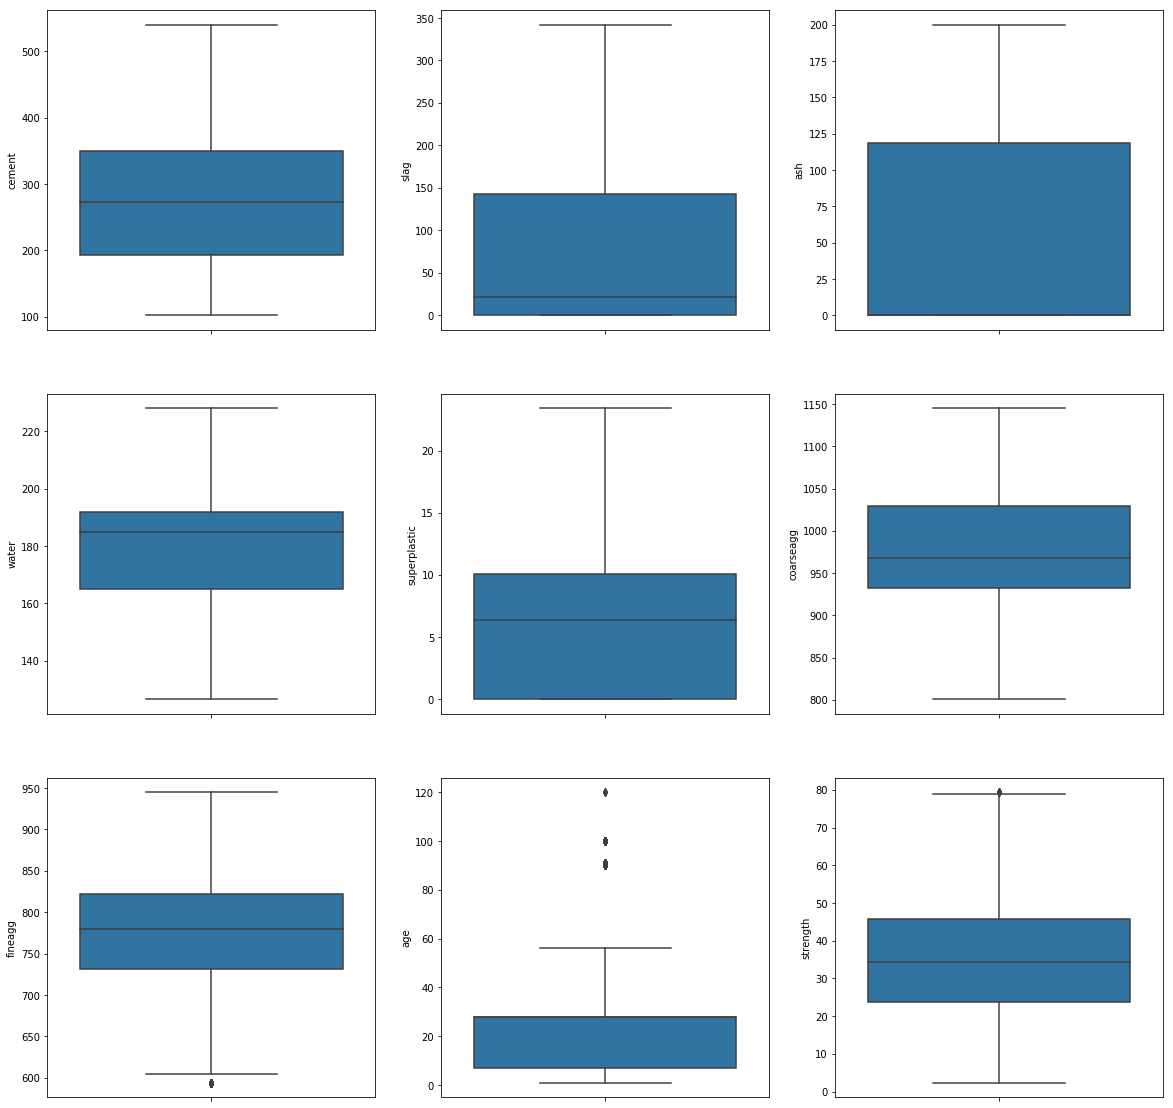

In [320]:
# Box Plot to check outlier presence
def generate_box_plots(data, num_rows=3, num_cols=3, hue_col=None):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
    for i, column in enumerate(data.columns):
        sns.boxplot(y = column, hue=hue_col, data=data, ax=axes[i//3,i%3])
        
        
generate_box_plots(concrete_df)

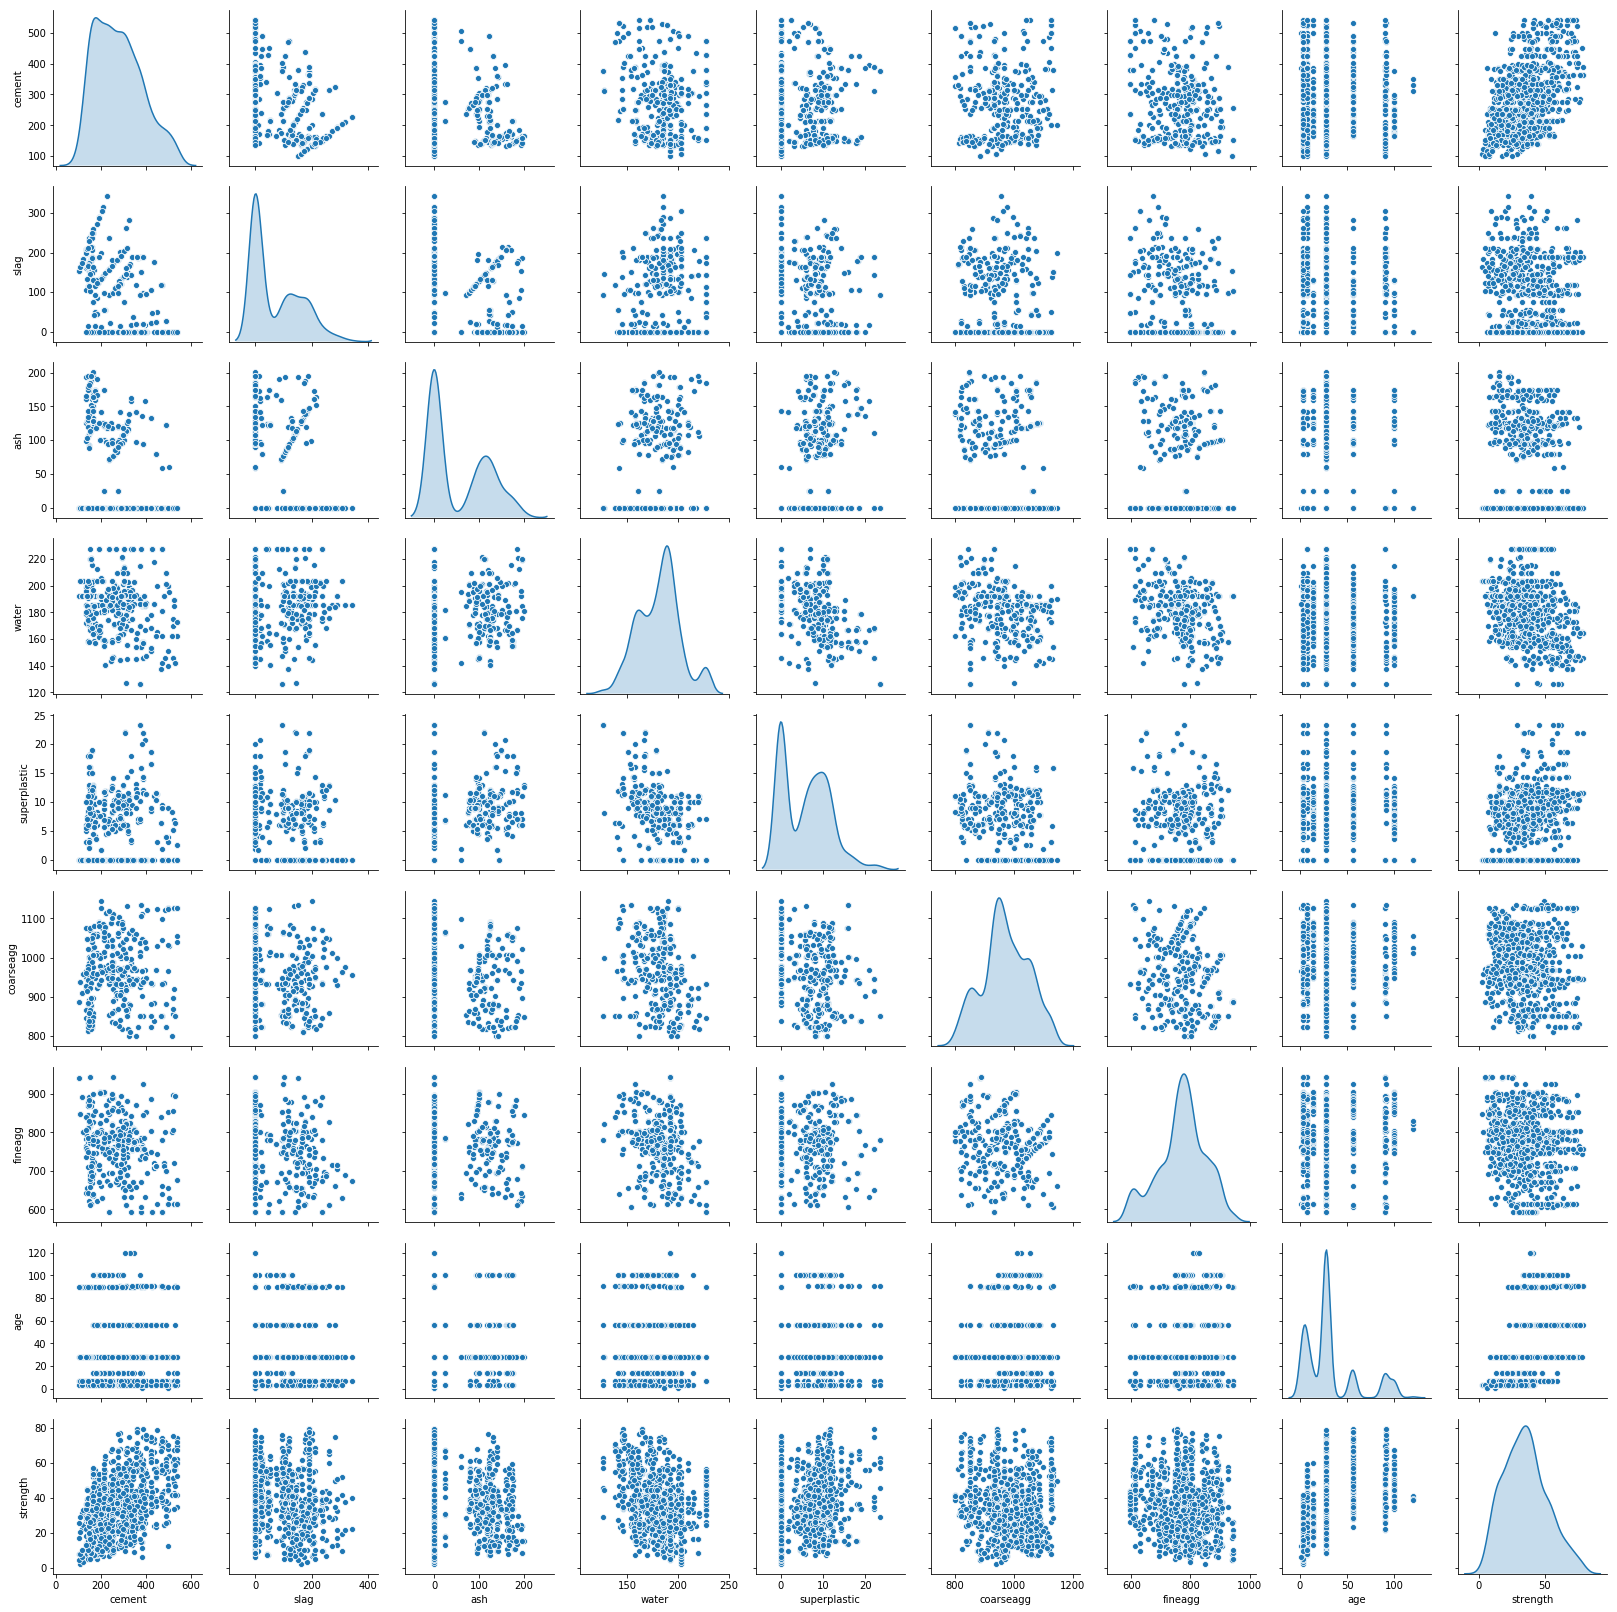

In [426]:
# Multivariate analysis using pair plot to identify relationships between attributes
sns.pairplot(concrete_df, diag_kind="kde")

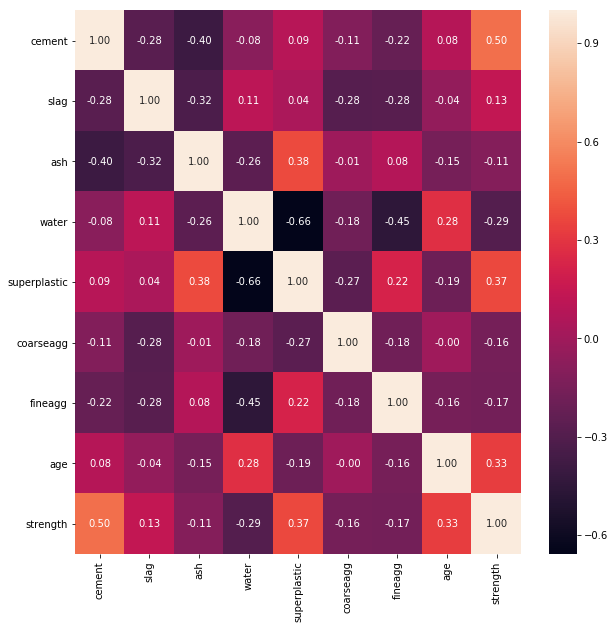

In [152]:
plt.subplots(figsize=(10,10))
sns.heatmap(concrete_df.corr(), fmt=".2f", annot=True)

On the basis of pair plot and correlation matrix, it seems that cement, superplastic and age has a significant correlation with strength, from which cement is the strongest predictor

In [447]:
# Check for null values
concrete_df.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [450]:
# Check for 0 values
concrete_df.replace(0, np.nan).isna().sum()

cement            0
slag            471
ash             566
water             0
superplastic    379
coarseagg         0
fineagg           0
age               0
strength          0
dtype: int64

There are no null values. however, data has a lot of 0 values in slag(471), ash(566) and superplastic(379) but treating the 0s as missing values results in a lot of outliers. So it can be concluded that 0 is a acceptable value for these fields.

In [455]:
# Outlier treatment using median

for column in concrete_df.columns:
    q1, q2, q3 = concrete_df[column].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    outlier_up_cond = concrete_df[column] > q3 + 1.5 * IQR
    outlier_down_cond = concrete_df[column] < q1 - 1.5 * IQR
    concrete_df[column] = np.where(outlier_up_cond | outlier_down_cond, q2, concrete_df[column])  

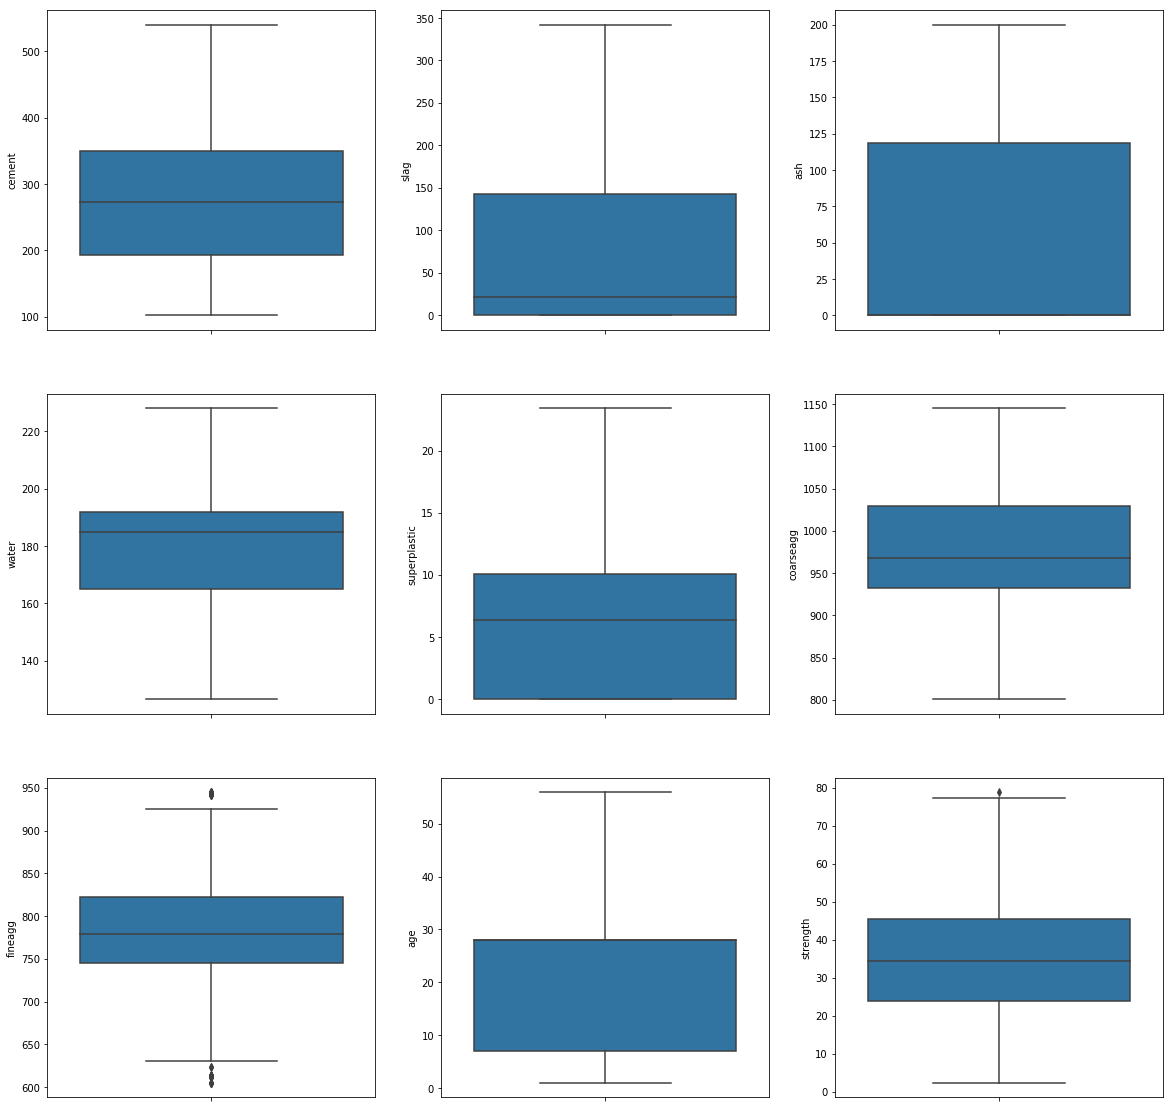

In [456]:
# Box plot post outlier treatment
generate_box_plots(concrete_df)

Post outlier treatment, we can see that most of the features are free from outliers

In [293]:
# Scaling the data using zscore, separating the predictors and target for train and test split
concrete_df_scaled = concrete_df.apply(zscore)

X = concrete_df_scaled.drop("strength", axis=1)
Y = concrete_df_scaled["strength"]

In [294]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

## Deliverable 2 - Feature Engineering Techniques

In [295]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
print ("Lasso model:", (lasso.coef_))

Lasso model: [ 0.44809348  0.14394514 -0.         -0.05773007  0.17133925 -0.
 -0.          0.41087206]


In [296]:
print(lasso.score(x_train, y_train))
print(lasso.score(x_test, y_test))

0.6569692508682634
0.5969846756135812


In [298]:
for deg in range(2,7):
    poly_features = PolynomialFeatures(deg)
    X_poly = pd.DataFrame(poly_features.fit_transform(X))

    x_train_poly, x_test_poly, y_train, y_test = train_test_split(X_poly, Y, test_size=0.3, random_state=1)

    lasso = Lasso(alpha=0.1)
    lasso.fit(x_train_poly, y_train)
    print("Training score for polynomial of degree", deg, ": ", lasso.score(x_train_poly, y_train))
    print("Test score for polynomial of degree", deg, ": ", lasso.score(x_test_poly, y_test))

Training score for polynomial of degree 2 :  0.6947932300827648
Test score for polynomial of degree 2 :  0.6331390779560016
Training score for polynomial of degree 3 :  0.6982980101703324
Test score for polynomial of degree 3 :  0.6323541851991794
Training score for polynomial of degree 4 :  0.7140194815100793
Test score for polynomial of degree 4 :  0.6540148011785225
Training score for polynomial of degree 5 :  0.7259894809846872
Test score for polynomial of degree 5 :  0.6632464970049878
Training score for polynomial of degree 6 :  0.7362554108525169
Test score for polynomial of degree 6 :  0.6195006204727947


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3902259476258507, tolerance: 0.0705916321152169
  positive)


Text(0.5,1,'Selecting k with the Elbow Method')

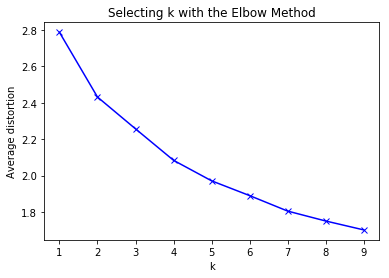

In [299]:
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(X_Scaled)
    prediction=model.predict(X_Scaled)
    meanDistortions.append(sum(np.min(cdist(X_Scaled, model.cluster_centers_, 'euclidean'), axis=1)) / X_Scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')


In [445]:
gauss_clusters=KMeans(5)
gauss_clusters.fit(X_Scaled)
prediction=gauss_clusters.predict(X_Scaled)

#Append the prediction
concrete_df_group = concrete_df.copy()
concrete_df_group["Group"] = prediction
concrete_df_group.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,Group
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51,3
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22,3
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023D856DDB70>,
      dtype=object)

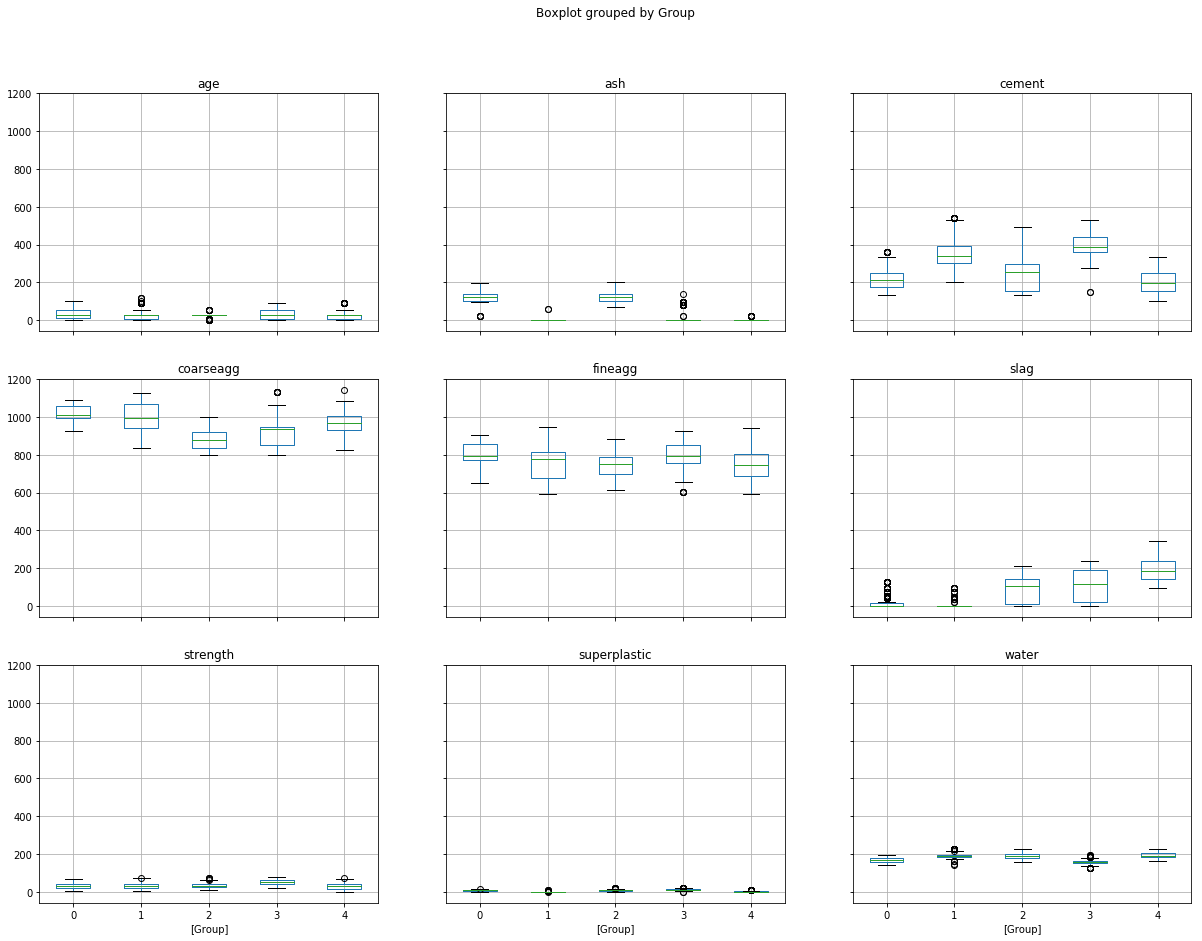

In [430]:
concrete_df_group.boxplot(by="Group", layout=(3,3), figsize=(20, 15))

Findings:
    1. As all the groups have overlapping value, it is visible that there are no distinct clusters
    2. Clustering the data will not give much advantage in prediction due to lack of distinct clusters  

## Deliverable 3. Create the model 

In [356]:
# Fitting a RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=50, random_state=1)
rf.fit(x_train, y_train)

print(rf.score(x_train, y_train))
print(rf.score(x_test, y_test))

0.9748797221136173
0.880080495626519


In [357]:
# Checking for Feature Importance
for i, column in enumerate(X.columns):
    print("Importance value of", column, "is", rf.feature_importances_[i])

Importance value of cement is 0.33481021754819595
Importance value of slag is 0.07065417014741308
Importance value of ash is 0.017472946989154806
Importance value of water is 0.11995105117103312
Importance value of superplastic is 0.05155036387091986
Importance value of coarseagg is 0.030549582147248348
Importance value of fineagg is 0.035563983705015116
Importance value of age is 0.3394476844210197


Findings:
    1. Features cement and age are the most important features
    2. Features ash, caoreagg and fineagg do not add much value as predictors hence these can be dropped without losing
       much model accuracy

## Deliverable 4. Tuning the model

Suitable algorithms : 
    1. LinearRegression 
    2. DecisionTreeRegressor
    3. RandomForestRegressor
    4. RidgeRegression
    5. LassoRegression
    6. BaggingRegressor
    7. AdaBoostRegressor 

In [366]:
# Removing the feature with low importance values
X_imp = X.drop(["ash", "coarseagg", "fineagg"], axis=1)
x_train_imp, x_test_imp, y_train, y_test = train_test_split(X_imp, Y, test_size=0.3, random_state=1)

In [367]:
rf.fit(x_train_imp, y_train)

print(rf.score(x_train_imp, y_train))
print(rf.score(x_test_imp, y_test))

0.9753531211297962
0.8794920818771709


In [434]:
# Applying RandomizedSearchCV for hyperparameter tuning 
max_depth = list(range(4,11))
max_depth.append("None")
min_samples_leaf = list(range(2,6))
n_estimators = [10, 15, 20, 50, 100]

random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'log2', 'None'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=1, n_jobs=-1,
                              return_train_score=True)

rf_random.fit(x_train_imp, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [435]:
# Best set of parameters from RandomSearchCV
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'bootstrap': True}

In [443]:
# Applying Best Estimator to get the accuracy scores
best_rf = rf_random.best_estimator_ 
print("Train Score:", best_rf.score(x_train_imp, y_train))
print("Test Score:", best_rf.score(x_test_imp , y_test))

Train Score: 0.9443477522687335
Test Score: 0.863707305564383


In [444]:
# KFold CrossValidation to calculate Model performance range
kfold = KFold(n_splits=10, random_state=1)
results = cross_val_score(best_rf, X_imp, Y, cv=kfold)
mean = results.mean()*100.0
std_dev = results.std()*100.0
accuracy_95_low = (results.mean()-1.96*results.std())*100
accuracy_95_high = (results.mean()+1.96*results.std())*100

print("Mean Accuracy: %.2f%%, Standard Deviation:%.2f%%" % (mean, std_dev))
print("95%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_95_low, accuracy_95_high))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Mean Accuracy: 86.77%, Standard Deviation:2.84%
95% confidence level Model performance range is from 81.20% to 92.35%
